In [20]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor 
from sklearn.svm import SVR 
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.model_selection import RandomizedSearchCV 
from catboost import CatBoostRegressor 
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from math import sqrt 

In [3]:
df = pd.read_csv('data/Price_Agriculture_commodities_Week.csv', parse_dates=['Arrival_Date'], dayfirst=True) 
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23093 entries, 0 to 23092
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   State         23093 non-null  object        
 1   District      23093 non-null  object        
 2   Market        23093 non-null  object        
 3   Commodity     23093 non-null  object        
 4   Variety       23093 non-null  object        
 5   Grade         23093 non-null  object        
 6   Arrival_Date  23093 non-null  datetime64[ns]
 7   Min Price     23093 non-null  float64       
 8   Max Price     23093 non-null  float64       
 9   Modal Price   23093 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 1.8+ MB


(None,
      State District    Market              Commodity      Variety Grade  \
 0  Gujarat   Amreli  Damnagar  Bhindi(Ladies Finger)       Bhindi   FAQ   
 1  Gujarat   Amreli  Damnagar                Brinjal        Other   FAQ   
 2  Gujarat   Amreli  Damnagar                Cabbage      Cabbage   FAQ   
 3  Gujarat   Amreli  Damnagar            Cauliflower  Cauliflower   FAQ   
 4  Gujarat   Amreli  Damnagar      Coriander(Leaves)    Coriander   FAQ   
 
   Arrival_Date  Min Price  Max Price  Modal Price  
 0   2023-07-27     4100.0     4500.0       4350.0  
 1   2023-07-27     2200.0     3000.0       2450.0  
 2   2023-07-27     2350.0     3000.0       2700.0  
 3   2023-07-27     7000.0     7500.0       7250.0  
 4   2023-07-27     8400.0     9000.0       8850.0  )

In [4]:
dups = df.duplicated().sum() 
print(dups)

0


In [5]:
print(df[['Min Price','Max Price', 'Modal Price']].describe())

           Min Price      Max Price    Modal Price
count   23093.000000   23093.000000   23093.000000
mean     4187.077045    4976.034260    4602.917742
std      5472.783385    6277.308057    5843.822711
min         0.000000       0.000000       0.830000
25%      1750.000000    2000.000000    1955.000000
50%      2725.000000    3400.000000    3000.000000
75%      5000.000000    6000.000000    5500.000000
max    223500.000000  227500.000000  225500.000000


In [6]:
print(df.nunique()) 
print(df['Commodity'].value_counts().head(10))

State             27
District         403
Market          1289
Commodity        234
Variety          452
Grade              4
Arrival_Date       7
Min Price       1793
Max Price       2073
Modal Price     2071
dtype: int64
Commodity
Potato                   1205
Onion                    1134
Brinjal                  1033
Green Chilli              931
Bhindi(Ladies Finger)     860
Cucumbar(Kheera)          712
Bottle gourd              693
Tomato                    671
Banana                    669
Wheat                     639
Name: count, dtype: int64


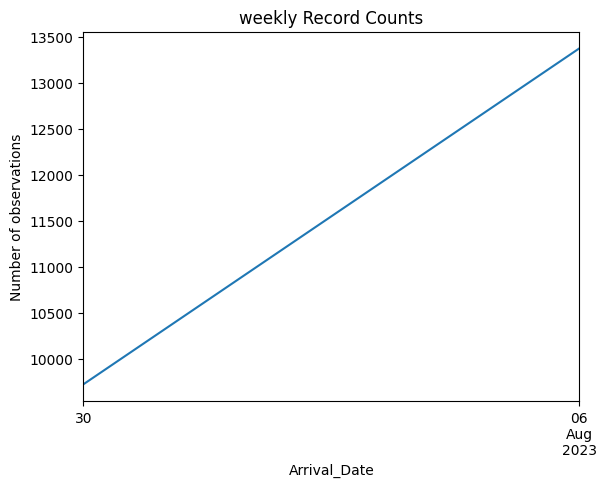

In [7]:
weekly = df.set_index('Arrival_Date')['Modal Price'].resample('W').count() 
weekly.plot(title='weekly Record Counts') 
plt.ylabel('Number of observations') 
plt.show() 

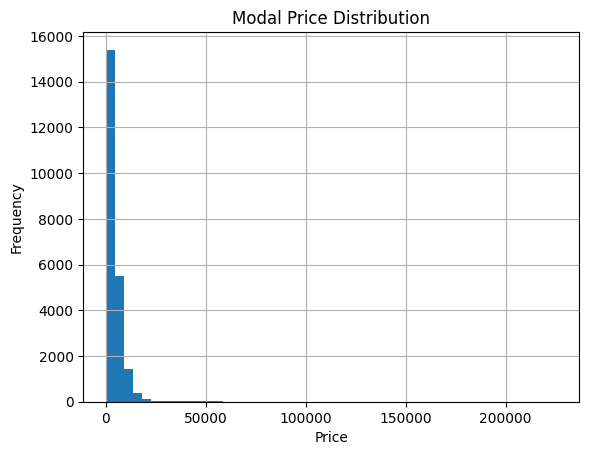

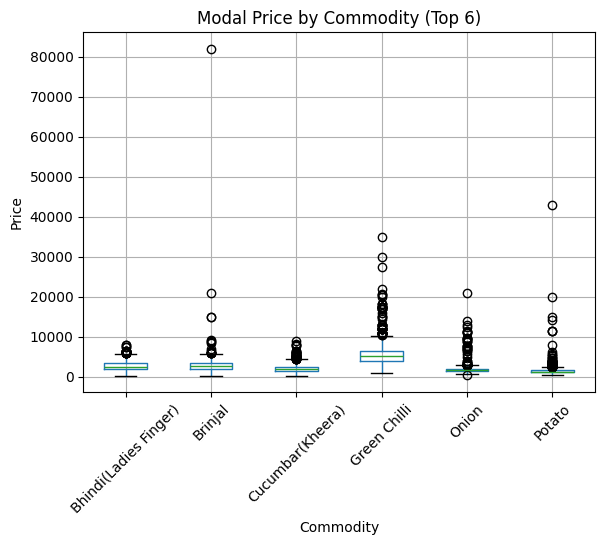

In [8]:
# overall histogram
df['Modal Price'].hist(bins=50)
plt.title('Modal Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# boxplot by Commodity (pick top N)
top_com = df['Commodity'].value_counts().nlargest(6).index
df_box = df[df['Commodity'].isin(top_com)]
df_box.boxplot(column='Modal Price', by='Commodity', rot=45)
plt.title('Modal Price by Commodity (Top 6)')
plt.suptitle('')
plt.ylabel('Price')
plt.show()


In [9]:
bad = df[~((df['Min Price'] <= df['Modal Price']) & (df['Modal Price'] <= df['Max Price']))]
print(f"Rows with inconsistent prices: {len(bad)}")
# Investigate or drop these rows

Rows with inconsistent prices: 28


In [10]:
# count per Commodity
com_counts = df['Commodity'].value_counts()

# list those with <10 rows
rare_coms = com_counts[com_counts < 100].index.tolist()
print(f"Commodities with fewer than 100 records ({len(rare_coms)} groups):\n", rare_coms)


Commodities with fewer than 100 records (179 groups):
 ['Pear(Marasebu)', 'Cluster beans', 'Green Gram (Moong)(Whole)', 'Pineapple', 'Sesamum(Sesame,Gingelly,Til)', 'Little gourd (Kundru)', 'Fish', 'Amaranthus', 'Barley (Jau)', 'Black Gram Dal (Urd Dal)', 'Peas Wet', 'Mustard Oil', 'Plum', 'Coconut', 'Arecanut(Betelnut/Supari)', 'Beans', 'Bengal Gram Dal (Chana Dal)', 'Jack Fruit', 'Amphophalus', 'Tapioca', 'Guava', 'Mango (Raw-Ripe)', 'Corriander seed', 'Tinda', 'Elephant Yam (Suran)', 'Masur Dal', 'White Peas', 'Methi(Leaves)', 'Leafy Vegetable', 'Lime', 'Green Gram Dal (Moong Dal)', 'Ginger(Dry)', 'Sweet Pumpkin', 'Peas(Dry)', 'Chilly Capsicum', 'Onion Green', 'Water Melon', 'Cummin Seed(Jeera)', 'Copra', 'Guar Seed(Cluster Beans Seed)', 'Field Pea', 'Black pepper', 'Papaya (Raw)', 'Squash(Chappal Kadoo)', 'Grapes', 'Turmeric', 'Jute', 'Sweet Potato', 'Methi Seeds', 'Sugar', 'Yam (Ratalu)', 'Dry Chillies', 'Chikoos(Sapota)', 'Wood', 'Orange', 'Knool Khol', 'Peas cod', 'Round gourd',

In [11]:
df = df[~df['Commodity'].isin(rare_coms)]

In [12]:
# count per Commodity
com_counts = df['Commodity'].value_counts()

# list those with <10 rows
rare_coms = com_counts[com_counts < 10].index.tolist()
print(f"Commodities with fewer than 10 records ({len(rare_coms)} groups):\n", rare_coms)

Commodities with fewer than 10 records (0 groups):
 []


In [13]:
# Number of unique commodities
num_unique_commodities = df['Commodity'].nunique()
print(f"Number of unique commodities: {num_unique_commodities}")

# Frequency count of each commodity
commodity_counts = df['Commodity'].value_counts()
print("\nTop commodities by record count:\n", commodity_counts.head())

# If you want to display all:
print(commodity_counts.to_string())

Number of unique commodities: 55

Top commodities by record count:
 Commodity
Potato                   1205
Onion                    1134
Brinjal                  1033
Green Chilli              931
Bhindi(Ladies Finger)     860
Name: count, dtype: int64
Commodity
Potato                           1205
Onion                            1134
Brinjal                          1033
Green Chilli                      931
Bhindi(Ladies Finger)             860
Cucumbar(Kheera)                  712
Bottle gourd                      693
Tomato                            671
Banana                            669
Wheat                             639
Bitter gourd                      610
Pumpkin                           588
Cabbage                           531
Apple                             488
Paddy(Dhan)(Common)               470
Cauliflower                       465
Rice                              443
Bengal Gram(Gram)(Whole)          348
Lemon                             325
Garlic        

In [14]:
df = pd.read_csv("data/Price_Agriculture_commodities_Week.csv", parse_dates=["Arrival_Date"], dayfirst=True)
counts = df["Commodity"].value_counts() 
keep = counts[counts >= 100].index 
df = df[df["Commodity"].isin(keep)].reset_index(drop=True) 

In [15]:
# 2. Feature engineering: lags, rolling, calendar
df = df.sort_values(["Commodity", "Market", "Arrival_Date"])
group_cols = ["Commodity", "Market"]

# Prepare a list to track the lag column names
lag_cols = []

# Create proper lag‑1 columns
for col in ["Modal Price", "Min Price", "Max Price"]:
    clean = col.replace(" ", "").lower()          # remove the space
    lag_name = f"lag1_{clean}"
    df[lag_name] = df.groupby(group_cols)[col].shift(1)
    lag_cols.append(lag_name)

# 7‑day rolling mean of modal price up to the previous day
df["roll7_modal"] = (
    df.groupby(group_cols)["Modal Price"]
      .apply(lambda x: x.shift(1).rolling(window=7).mean())
      .reset_index(level=group_cols, drop=True)
)

# Calendar features
df["year"]        = df["Arrival_Date"].dt.year
df["month"]       = df["Arrival_Date"].dt.month
df["day_of_week"] = df["Arrival_Date"].dt.dayofweek

# Now drop rows missing any of our engineered features
df_model = df.dropna(subset=lag_cols + ["roll7_modal"]).copy()

# Define target and features
target = "Modal Price"
feature_cols = (
    lag_cols +                  # ['lag1_modalprice','lag1_minprice','lag1_maxprice']
    ["roll7_modal","year","month","day_of_week","Commodity","Market"]
)

X = df_model[feature_cols]
y = df_model[target]

# Then you can split, build pipelines, etc.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [16]:
numeric_feats = lag_cols + ["roll7_modal", "year", "month", "day_of_week"]
cat_feats     = ["Commodity", "Market"]
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats)
])

In [17]:
models = {
    "KNN": (
        KNeighborsRegressor(),
        {"reg__n_neighbors": [3, 5, 7, 9]}
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=42),
        {"reg__max_depth": [None, 5, 10, 20],
         "reg__min_samples_leaf": [1, 5, 10]}
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=42, n_jobs=-1),
        {"reg__n_estimators": [100, 200],
         "reg__max_depth": [None, 10, 20],
         "reg__min_samples_leaf": [1, 5]}
    ),
    "AdaBoost": (
        AdaBoostRegressor(random_state=42),
        {"reg__n_estimators": [50, 100],
         "reg__learning_rate": [0.01, 0.1, 1]}
    ),
    "SVR": (
        SVR(),
        {"reg__C": [0.1, 1, 10],
         "reg__gamma": ["scale", "auto"],
         "reg__kernel": ["rbf"]}
    ),
    "Linear": (
        LinearRegression(),
        {}
    ),
    "Ridge": (
        Ridge(random_state=42),
        {"reg__alpha": [0.1, 1, 10, 50]}
    ),
    "Lasso": (
        Lasso(random_state=42, max_iter=5000),
        {"reg__alpha": [0.001, 0.01, 0.1, 1]}
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, n_jobs=-1),
        {"reg__n_estimators": [100, 200],
         "reg__learning_rate": [0.01, 0.05, 0.1],
         "reg__max_depth": [3, 6, 10]}
    ),
    "CatBoost": (
        CatBoostRegressor(random_seed=42, silent=True),
        {"reg__iterations": [200, 500],
         "reg__depth": [4, 6],
         "reg__learning_rate": [0.05, 0.1]}
    ),
}

results = []
best_overall = {"rmse": np.inf, "model": None, "name": None}

for name, (est, param_grid) in models.items():
    pipe = Pipeline([("pre", preprocessor), ("reg", est)])
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=10,
        cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    best_pipe = search.best_estimator_
    preds = best_pipe.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, preds))
    mae  = mean_absolute_error(y_test, preds)
    r2   = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "Best_Params": search.best_params_,
        "Test_RMSE": rmse,
        "Test_MAE": mae,
        "Test_R2": r2
    })

    if rmse < best_overall["rmse"]:
        best_overall = {"rmse": rmse, "model": best_pipe, "name": name}


results_df = pd.DataFrame(results).sort_values("Test_RMSE").reset_index(drop=True)
print(results_df)

results_df = pd.DataFrame(results).sort_values("Test_RMSE").reset_index(drop=True)
print(results_df)

/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/joyaljijo/Developer/pragati/notebook/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n

          Model                                        Best_Params  \
0       XGBoost  {'reg__n_estimators': 200, 'reg__max_depth': 3...   
1  RandomForest  {'reg__n_estimators': 200, 'reg__min_samples_l...   
2      AdaBoost  {'reg__n_estimators': 100, 'reg__learning_rate...   
3      CatBoost  {'reg__learning_rate': 0.05, 'reg__iterations'...   
4  DecisionTree  {'reg__min_samples_leaf': 10, 'reg__max_depth'...   
5           KNN                            {'reg__n_neighbors': 9}   
6         Ridge                                 {'reg__alpha': 10}   
7           SVR  {'reg__kernel': 'rbf', 'reg__gamma': 'scale', ...   
8         Lasso                               {'reg__alpha': 0.01}   
9        Linear                                                 {}   

     Test_RMSE     Test_MAE    Test_R2  
0   591.718564   470.838569   0.456091  
1   684.806976   534.292346   0.271495  
2   705.417599   502.620951   0.226984  
3   757.197326   565.848721   0.109335  
4   940.692587   755.783

In [ ]:
best_model = best_overall['model'] 
print(f"Best model: {best_overall['name']} with RMSE={best_overall['rmse']:.2f}")


Best model: XGBoost with RMSE=591.72


In [21]:
joblib.dump(best_model, 'market_price_model.pkl') 

['market_price_model.pkl']